# Mathematical Foundations of Computer Graphics and Vision 2023
## Exercise 1 - Robust Estimation and Optimization

In this exercise you will apply what you learned about robust optimization, especially RANSAC and Iteratively Reweighted Least Squares (IRLS). You will implement RANSAC for circle fitting in the presence of outliers, IRLS for line fitting with $L_1$ norm, and LP for line fitting with $L_1$ and $L_\infty$ norms.

We have implemented a skeleton notebook and you have to fill out blocks marked with `TODO`. Please refrain from modifying the notebook outside of the `START` and `END` blocks for the coding problems apart from new cells you create.

<b style="color:red">Use numpy vectorization</b> instead of python loops where explicitly noted. We may deduct points if your code runs unreasonably slow due (see the "test case" cell). 

In [2]:
%matplotlib inline
import math
from typing import Tuple, List, Optional
import itertools
from collections import namedtuple

import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt


np.random.seed(123)

## Part 1: RANSAC for circle fitting

In [3]:
# Default parameters
N = 100  # number of total points
D = 10  # half-domain size
tau = 0.1  # inlier distance threshold

### 1.1. Data Generation and Model Fitting

In [4]:
class Polynomial:
    def __init__(self, coefficients):
        self._coefficients = coefficients

    def __repr__(self):
        return f"Polynomial({self._coefficients.tolist()})"
        
    @property
    def degree(self):
        return len(self._coefficients) - 1

    def evaluate(self, x):
        """
        x - (N,1) array with the `x` coordinates

        Returns - (N,1) array with their `y` coordinates
        """

        y = np.ones_like(x)

        # TODO: evaluate the polynomial at points x
        # Use numpy vectorization!
        # START
        y = np.polyval(np.flip(self._coefficients), x)
        # END
        
        return y
    
    def is_inlier(self, points: np.ndarray, threshold: float = tau):
        """
        points - Nx2 array with the data points

        Returns - bool vector of size N, where i-th element indicates if i-th point of `points` is an inlier
        """
        is_inlier = np.ones((points.shape[0],), dtype=bool)

        # TODO : Fill vector `is_inlier`, for i-th element to indicate if i-th point of `points` is an inlier
        # Use `self.evaluate`
        # Use numpy vectorization!
        # START
        # |(f(x) - y)| <= tau
        is_inlier = np.less_equal(np.abs(self.evaluate(points[:,0]) - points[:,1]), tau)
        # END
        
        return is_inlier
        
    def generate_points(self, r: float, n_points: int = N) -> Tuple[np.ndarray, np.ndarray]:
        """
        r - outlier ratio
        n_points - number of points to generate

        Returns - tuple of inliers and outliers, each defined as an Nx2 array of the respective points
        """
        n_outliers = int(n_points * r)
        n_inliers = n_points - n_outliers

        # inliers = np.random.uniform(-D, D, (n_inliers, 2))
        # outliers = np.random.uniform(-D, D, (n_outliers, 2))

        # TODO : Implement Task 1.1. Make use of `self.evaluate` and `self.is_inlier` for that
        # START

        # Generate inliers
        n_generated_inliers = 0
        # Use empty after debugging for better speed
        inliers = np.empty((n_inliers, 2))
        while n_generated_inliers < n_inliers:
            # Generate (n_inliers - n_generated_inliers) x and y coords
            generated_xs = np.random.uniform(-D, D, (n_inliers - n_generated_inliers))
            # Add noise on inliers
            generated_ys = self.evaluate(generated_xs) + np.random.uniform(-tau, tau, generated_xs.size)
            # Filter out points outside of domain
            is_in_domain = np.less_equal(np.abs(generated_ys), D)
            n_generated_in_domain = np.sum(is_in_domain)
            generated_ys_in_domain = np.extract(is_in_domain, generated_ys)
            generated_xs_in_domain = np.extract(is_in_domain, generated_xs)
            np.put(inliers[:,0], np.arange(n_generated_inliers, (n_generated_inliers + n_generated_in_domain)), generated_xs_in_domain)
            np.put(inliers[:,1], np.arange(n_generated_inliers, (n_generated_inliers + n_generated_in_domain)), generated_ys_in_domain)
            n_generated_inliers += n_generated_in_domain

        # Generate outliers
        n_generated_outliers = 0
        outliers = np.empty((n_outliers, 2))
        while n_generated_outliers < n_outliers:
            generated_outliers = np.random.uniform(-D, D, ((n_outliers-n_generated_outliers), 2))
            condition_outliers = np.logical_not(self.is_inlier(generated_outliers))
            n_generated_as_outlier = np.sum(condition_outliers)
            generated_xs_as_outlier = np.extract(condition_outliers, generated_outliers[:,0])
            generated_ys_as_outlier = np.extract(condition_outliers, generated_outliers[:,1])
            np.put(outliers[:,0], np.arange(n_generated_outliers, (n_generated_outliers + n_generated_as_outlier)), generated_xs_as_outlier)
            np.put(outliers[:,1], np.arange(n_generated_outliers, (n_generated_outliers + n_generated_as_outlier)), generated_ys_as_outlier)            
            n_generated_outliers += n_generated_as_outlier
        # END
        return inliers, outliers
    
    @staticmethod
    def fit(points: np.ndarray) -> "Polynomial":
        """
        points - Nx2 array

        Returns - (N-1)-th degree polynomial going through all the `points`
        """
        if points.shape[1] != 2:
            raise ValueError("Bad point dimmensions")

        deg = points.shape[0] - 1

        coefficients = np.zeros(deg + 1)
        
        # TODO : Compute the (N-1)th degree polynomial coefficients that goes through
        #        all the `points` and fill `coefficients`
        # You do not need to handle singular cases - you can just return zeros
        # START 
        coefficients = np.flip(np.polyfit(points[:,0], points[:,1], deg))
        # END 

        return Polynomial(coefficients)

#### Tests and Visualization

There is no need to modify these cells (but read the comments).

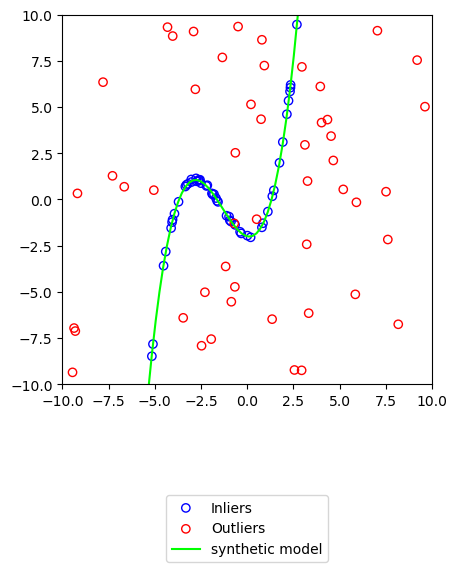

In [6]:
def plot_models(ax, inliers, outliers, synth_model: Polynomial, estimated_model: Optional[Polynomial] = None, title = None):
    ax.scatter(inliers[:, 0], inliers[:, 1], label="Inliers", c='none', edgecolors='blue')
    if outliers is not None:
        ax.scatter(outliers[:, 0], outliers[:, 1], label="Outliers", c='none', edgecolors='red')
    
    x = np.linspace(-10, 10, 100)[:, None]
    if estimated_model is not None:
        y = estimated_model.evaluate(x)
        ax.plot(x, y, color='black', label="estimated model")
        
    if title is not None:
        ax.set_title(title)
        
    y = synth_model.evaluate(x)
    ax.plot(x, y, color='lime', label='synthetic model')
    
    ax.set_ylim(bottom=-D, top=D)
    ax.set_xlim(left=-D, right=D)
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor=(0.5, -0.5), loc="lower center")

# Plotting the ground truth inliers/outliers 
poly_a = Polynomial(np.array([-2, -0.25, 1, 0.25]))
inliers, outliers = poly_a.generate_points(0.5)
fig, ax = plt.subplots()
plot_models(ax, inliers, outliers, poly_a)
plt.show()
plt.close(fig)

In [7]:
%%time
# A simple non-complete test case for the data generation part
# It should not take more than a few seconds to run it.

test_points = np.array([[-5.01341822, -7.11485119],
                        [ 1.86544097,  2.59891622],
                        [-0.37093626, -1.7499924 ],
                        [-7.8621905 , -0.45595404]])

inliers, outliers = poly_a.generate_points(0.5, 1000000)
assert poly_a.is_inlier(inliers).all(), "Bad inliers"
assert (~poly_a.is_inlier(outliers)).all(), "Bad outliers"
assert np.abs(inliers).max() <= D, "Inliers outside of the domain"
assert np.abs(outliers).max() <= D, "Outliers outside of the domain"

assert (poly_a.is_inlier(test_points) == np.array([*([True] * 3), False])).all(), "Failed test case"

CPU times: total: 250 ms
Wall time: 263 ms


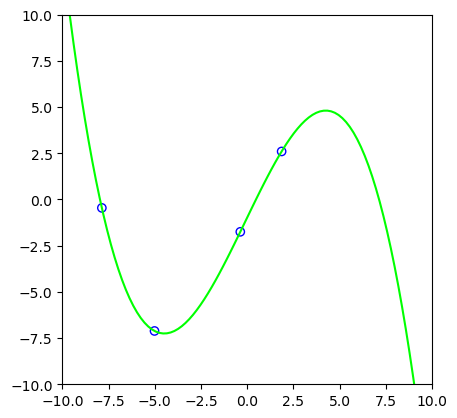

In [8]:
# Visualizing `fit` implementation. No need to edit this

def plot_fitted_poly(points, poly):
    fig, ax = plt.subplots()
    plot_models(ax, points, points[:0], poly)
    ax.get_legend().remove()
    plt.show()
    plt.close(fig)
    
poly = Polynomial.fit(test_points)

plot_fitted_poly(test_points, poly)

### 1.2. RANSAC

In [9]:
def get_ransac_iterations(r: float, sample_size: int, p: float) -> int:
    """
    r - outlier ratio
    sample_size - minimum data
    p - success rate
    
    Returns - number of RANSAC iterations to achieve `p` success rate 
    """
        
    # TODO : Compute the minimum number of RANSAC iterations necessary to achieve `p` success rate
    # START 
    n = math.ceil(math.log(1-p)/math.log(1-math.pow((1-r), sample_size)))
    # END 
    
    return n

In [10]:
def run_ransac(points: np.ndarray, n_iter: int, sample_size: int) -> Tuple[np.ndarray, np.ndarray, Polynomial]:
    """
    points - Nx2 array with the data points
    n_iter - number of ransac iterations
    sample_size - number of samples required to fit the model
    
    Returns - tuple of inliers and outliers, each defined as Nx2 arrays of the
              respective points, and the final Polynomial model
    """

    n_points = points.shape[0]
    
    # TODO : Implement 1.2 - RANSAC for model fitting
    # do it for n_iter and keep best
    # START
    n_max_inlier = 0
    for i in range(n_iter):
        sampled_points = np.random.choice(n_points, sample_size, False)
        poly_i = Polynomial.fit(points[sampled_points])
        # Inliers
        is_inlier = poly_i.is_inlier(points)
        inliers_i = np.empty((np.sum(is_inlier),2))
        inliers_i[:,0] = np.extract(is_inlier, points[:,0])
        inliers_i[:,1] = np.extract(is_inlier, points[:,1])
        # Outliers
        is_outlier = np.logical_not(is_inlier)
        outliers_i = np.empty((np.sum(is_outlier),2))
        outliers_i[:,0] = np.extract(is_outlier, points[:,0])
        outliers_i[:,1] = np.extract(is_outlier, points[:,1])
        if(inliers_i.shape[0] > n_max_inlier):
            inliers = inliers_i
            outliers = outliers_i
            poly = poly_i
            n_max_inlier = inliers_i.shape[0]

    # END     
    return inliers, outliers, poly

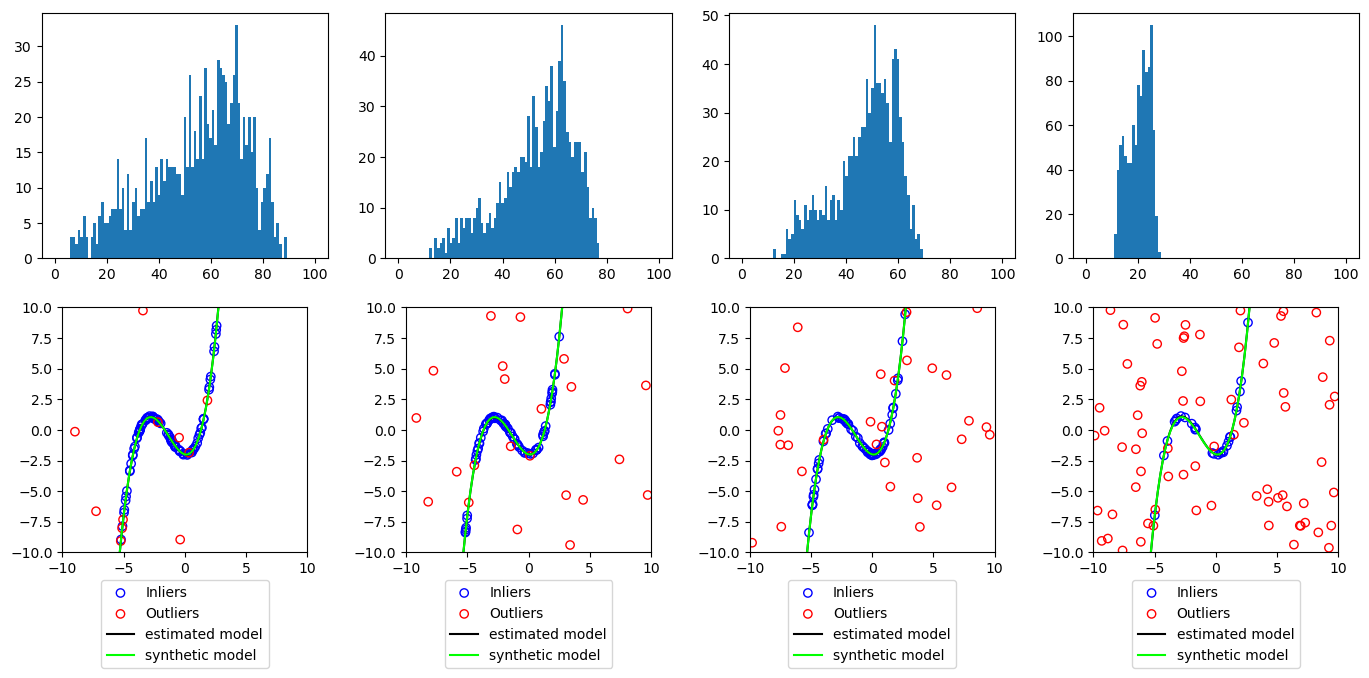

In [12]:
# Running RANSAC and populating histograms
# It may take some time to run, you can adjust N_RUNS to help with debugging
N_RUNS = 1000
OUTLIER_RATIOS = [0.05, 0.2, 0.3, 0.7]

def plot_ransac_results(synth_poly: Polynomial):
    fig, axes = plt.subplots(2, len(OUTLIER_RATIOS), figsize=(17, 7))

    for r, (ax_hist, ax_vis) in zip(OUTLIER_RATIOS, zip(*axes)): 
        inlier_histogram = np.zeros(N_RUNS)

        ransac_inliers = np.zeros((N_RUNS,2))
        ransac_outliers = np.zeros((N_RUNS,2))
        model = None

        # TODO : Fill `inlier_histogram` array and assign `ransac_inliers`,
        #        `ransac_outliers`, `model`
        # START
        synth_points = np.concatenate(synth_poly.generate_points(r))
        success_rate = 0.99
        sample_size = synth_poly.degree + 1
        n_ransac_iter = get_ransac_iterations(r, sample_size, success_rate)
        for i in range(N_RUNS):
            inliers_i, outliers_i, model_i = run_ransac(synth_points, n_ransac_iter, sample_size)
            inlier_histogram[i] = inliers_i.shape[0]
            # Save best ransac (highest number of inliers)
            if(inliers_i.shape[0] >= np.amax(inlier_histogram)):
                ransac_inliers = inliers_i
                ransac_outliers = outliers_i
                model = model_i

        # END
        ax_hist.hist(inlier_histogram, range=(0, N), bins=N+1)
        #print(ransac_inliers.shape[0])

        plot_models(ax_vis, ransac_inliers, ransac_outliers, synth_poly, model)

    plt.show()
    plt.close(fig)


plot_ransac_results(poly_a)

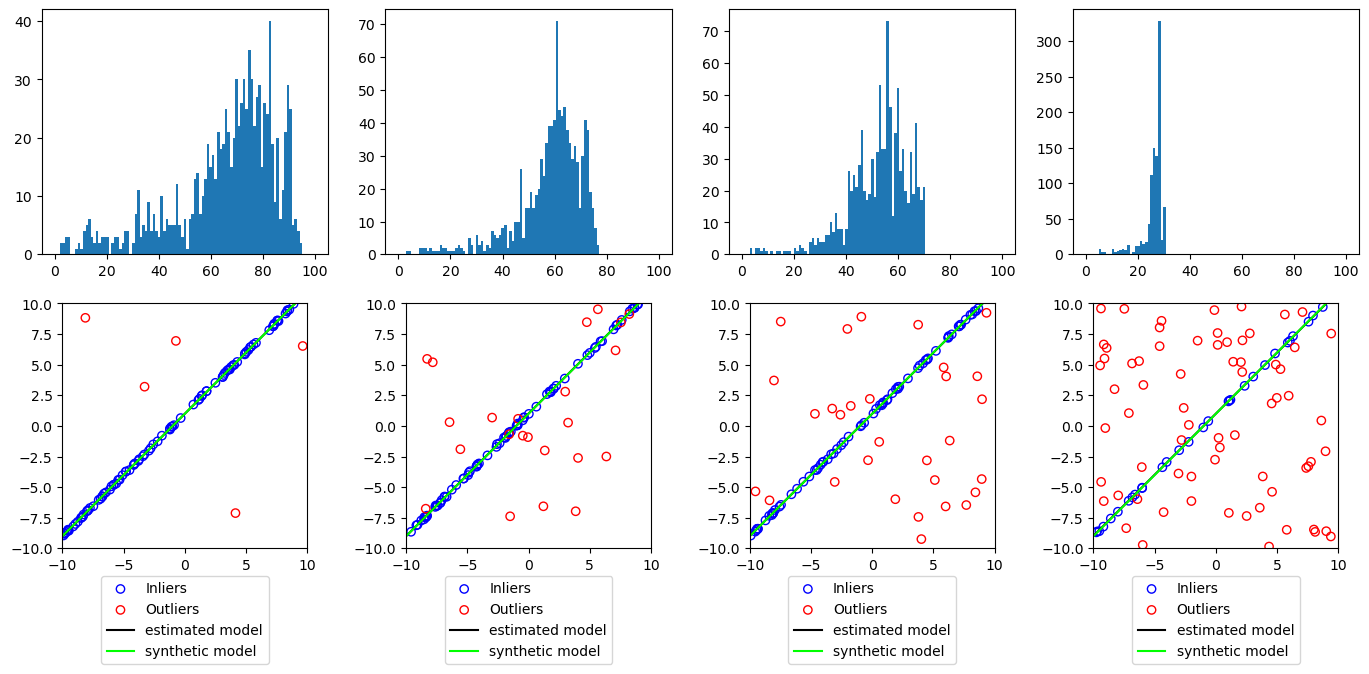

In [13]:
poly_b = Polynomial(np.array([1, 1]))
plot_ransac_results(poly_b)

### 1.3. Exhaustive search

In [14]:
def exhaustive_search(points: np.ndarray, sample_size) -> Tuple[np.ndarray, np.ndarray, Polynomial]:
    """
    points - Nx2 array with the data points
    sample_size - number of samples required to fit the model
    
    Returns - tuple of inliers and outliers, each defined as Nx2 arrays of the
              respective points, and the best model
    """

    n_points = points.shape[0]

    # TODO : Implement exhaustive search by trying all the combinations of minimal data points
    # START
    n_max_inliers = 0
    for pc in (itertools.combinations(points, sample_size)):
        npc = np.asarray(pc)
        # print(npc.shape)
        poly = Polynomial.fit(npc)
        # Check inlier count
        is_inlier = poly.is_inlier(points)
        n_is_inlier = np.sum(is_inlier)
        if(n_is_inlier>n_max_inliers):
            # Save best model
            model = poly
            # Inliers
            inliers = np.empty((np.sum(is_inlier),2))
            inliers[:,0] = np.extract(is_inlier, points[:,0])
            inliers[:,1] = np.extract(is_inlier, points[:,1])
            # Outliers
            is_outlier = np.logical_not(is_inlier)
            outliers = np.empty((np.sum(is_outlier),2))
            outliers[:,0] = np.extract(is_outlier, points[:,0])
            outliers[:,1] = np.extract(is_outlier, points[:,1])
            n_max_inliers = n_is_inlier


    # END 
    
    return inliers, outliers, model

Real inliers: 24
RANSAC inliers: 13
Exhaustive search inliers: 23


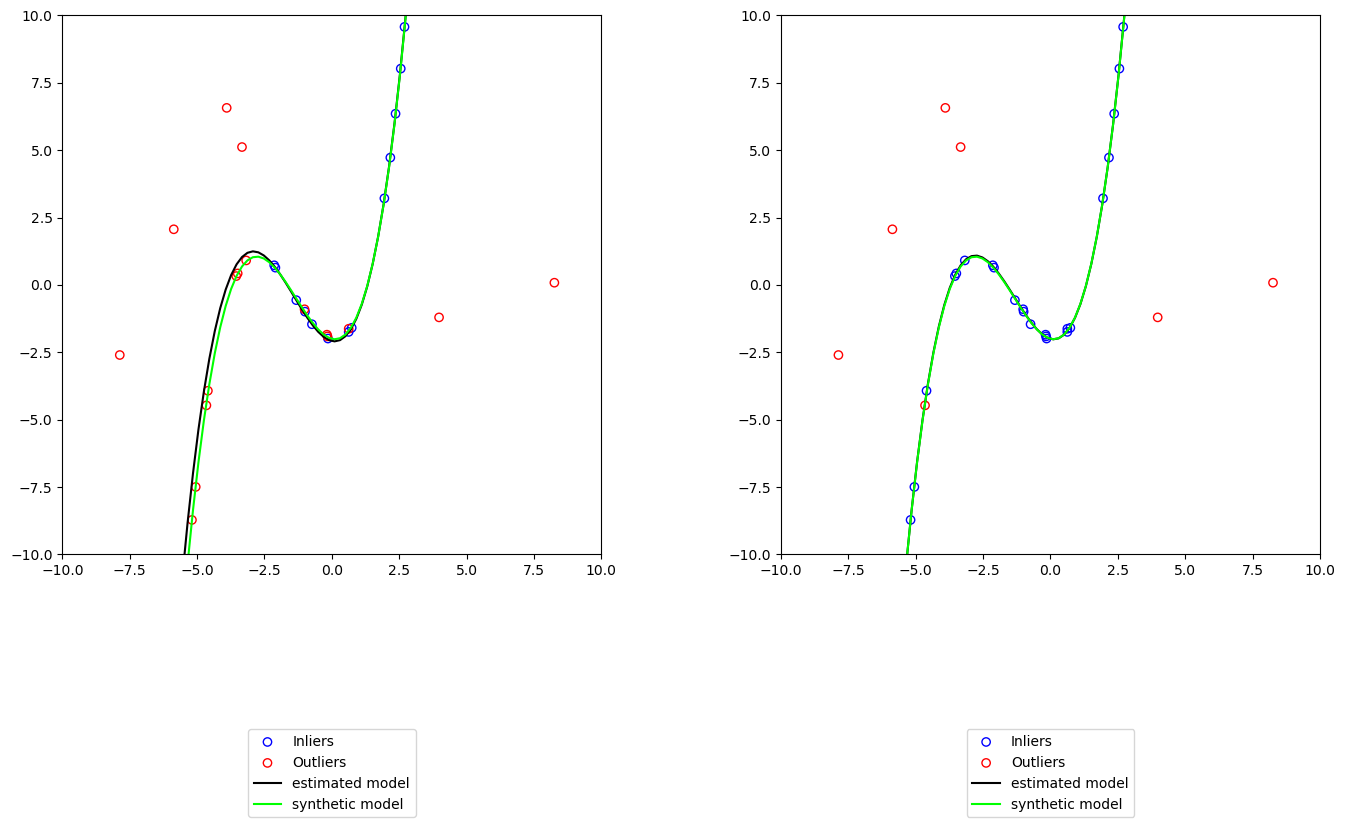

In [15]:
# Running exhaustive search. No need to edit this. Running on a reduced set of points
inliers, outliers = poly_a.generate_points(0.2, 30)
points = np.concatenate((inliers, outliers), 0)

sample_size = poly_a.degree + 1
n_iter = get_ransac_iterations(0.2, sample_size, 0.99)
ransac_inliers, ransac_outliers, ransac_model = run_ransac(points, n_iter, sample_size)

exhaustive_inliers, exhaustive_outliers, exhaustive_model = exhaustive_search(points, sample_size)

print(f"Real inliers: {len(inliers)}")
print(f"RANSAC inliers: {len(ransac_inliers)}")
print(f"Exhaustive search inliers: {len(exhaustive_inliers)}")

fig, axes = plt.subplots(1, 2, figsize=(17, 7))

plot_models(axes[0], ransac_inliers, ransac_outliers, poly_a, ransac_model)
plot_models(axes[1], exhaustive_inliers, exhaustive_outliers, poly_a, exhaustive_model)

plt.show()
plt.close(fig)

### Questions and Discussion 

<b style="color:red"> Question 1.1: </b> How many combinations (exhaustive search) exist for $N=100$ points? 

$C(N,k)$ combinations exist, where $N$ stands for the number of points, $k$ stands for the degree of estimated polynomial plus one and $C$ is the combination operation "$N\ choose\ k$". Exhaustive search goes through all the combinations of $deg(polynomial) + 1$ points since we need $deg(polynomial) + 1$ points to fit the polynomial on data.
For $poly_a$, which is a third degree polynomial we have: $C(100,4) = 3921225$ combinations possible.

<b style="color:red"> Question 1.2: </b> What about the number of RANSAC iterations with $r=5\%$, $20\%$, $30\%$ and $70\%$? 

s = deg poly + 1, give example over poly_a

<b style="color:red"> Question 1.3: </b> What about when $N=100,000$ points?

It is the same as questions $1.1$ and $1.2$ but now calculated with $N = 100,000$ instead. As an example of the combinatorial blowup, exhaustive search has to go through $C(100000, 4) = 4166416671249975000$ combinations for a third degree polynomial like $poly_a$. RANSAC has the same number of iterations.

<b style="color:red"> Question 1.4: </b> Does exhaustive search on all the combinations of data points guarantee the optimal solution (in terms of number of inliers)? Why?

In theory our sample size is large enough ie. we are trying to estimate the polynomial using $deg(polynomial) + 1$ points and the data points themselves have no noise, we can guarantee an optimal solution since we check every possible solution in the solution space. In the coding example, the data has noise, therefore exhaustive search can not find the "optimal solution" since the estimated model is not the same as sythetic model.

<b style="color:red"> Question 1.5: </b> Does RANSAC always find close to the optimal number of inliers? Why? If not, would increasing the number of RANSAC iterations always improve that?

Since we randomly sample points, we could get unlucky and not choose the optimal points the fit the polynomial onto. Increasing the number of RANSAC iterations generally helps, but it is not a guarantee since the sampling is still non-deterministic and we could still get unlucky.

<b style="color:red"> Question 1.6: </b> Discuss and compare the results obtained by RANSAC and exhaustive search in terms of
number of inliers, speed, number of synthesized inliers, etc.

Exhaustive search is significantly slower but guarantees the best result that RANSAC could have by simply iterating over all the possible options, where RANSAC non-deterministically chooses. In a best case scenario for RANSAC, RANSAC and exhaustive search have the same number of inliers but in practice, most of the times RANSAC can optimize for a lesser number of synthesized inliers.

<b style="color:red"> Question 1.7: </b> One of the challenges in using RANSAC for fitting polynomials is choosing appropriate values for the number of iterations and the inlier threshold. How would you go about selecting these values, and what factors should you consider when making this choice? Describe any tradeoffs that may exist between these two parameters, and provide an example scenario where a higher number of iterations or a higher inlier threshold might be preferable.

As shown in the Lecture Slides 1: Robust Fitting and Optimization (in slide 41), we can use $N = log(1-p)/log(1-(1-\epsilon)^s)$, where $\epsilon$ is the outlier ratio, $s$ is the sample size and $p$ is the probability that at least one sample has no outliers (usually set to 0.99). For the choice of the inlier threshold, we use heuristics, trial-and-error or adaptive threshold. In a scenario where the data is noisy, a higher inlier threshold is preferable to ensure that we can find a solution by classifying noisy inliers correctly. This will consequentially increase the inlier ratio resulting in lesser number of iterations needed for RANSAC.

## Part 2: IRLS and norms for line fitting

In [16]:
poly_b = Polynomial(np.array([1, 1]))

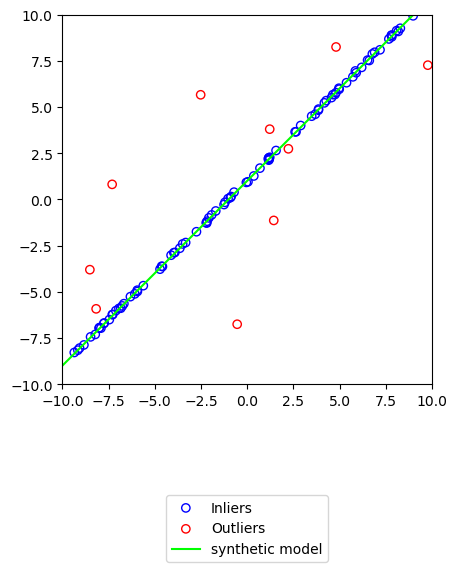

In [17]:
# Plotting the generated line that will be used for model fitting, no need to change this code    
inliers, outliers = poly_b.generate_points(0.1)
points = np.concatenate((inliers, outliers), 0)

fig, ax = plt.subplots()
plot_models(ax, inliers, outliers, poly_b)
plt.show()
plt.close(fig)

In [61]:
## Implement different line fitting algorithms

def fit_line_irls_l1(points: np.ndarray) -> Polynomial:
    """
    points - Nx2 array with the data points
    
    Returns - fitted Line
    """
    
    line = np.array([0, 0.5])
    
    # TODO : Implement line fitting with L-1 norm by using IRLS
    # START

    # Rewrite line equation as y = Ap where A = [[x 1]] and p = [[m], [c]], solve for p

    # END

    return Polynomial(line)


def fit_line_lp_l1(points: np.ndarray) -> Polynomial:
    """
    points - Nx2 array with the data points
    
    Returns - fitted Line
    """   

    # TODO : Implement line fitting with L-1 norm by using linear programming
    # START
    n_points = points.shape[0]

    # COMPUTE C
    # wi for each point, a, b 
    # [w1 w2 ... wn a b]
    # [1 1 ...   1 0 0]
    c = np.ones(n_points + 2)
    c[n_points] = 0
    c[n_points+1] = 0
    
    # COMPUTE Y
    #[y1 -y1 y2 -y2 ... yn -yn]
    b = np.empty(n_points * 2)
    for i in range(n_points):
        yi = points[i,1]
        b[2*i] = yi
        b[2*i+1] = -yi

    # COMPUTE A
    # This is how A tranposed looks like:
    # [-1 0 0 ... 0 x1 1]
    # [-1 0 0 ... 0 -x1 -1]
    # [0 -1 0 ... 0 x2 1]
    # [0 -1 0 ... 0 -x2 -1]
    # ...
    # [0 0 0 ... -1 xn 1]
    # [0 0 0 ... -1 -xn -1]
    A = np.zeros((n_points * 2, n_points + 2))
    for i in range(n_points):
        # Staggered diagonal minus ones
        A[2*i, i] = -1
        A[2*i+1, i] = -1
        # xis and +-1s for a and b
        xi = points[i,0]
        A[2*i, n_points] = xi
        A[2*i, n_points+1] = 1
        A[2*i+1, n_points] = -xi
        A[2*i+1, n_points+1] = -1

    # Call linprog
    res = linprog(c=c, A_ub=A, b_ub=b)
    line = np.take(res.x, [n_points, n_points + 1])

    # END

    
    return Polynomial(line)


def fit_line_lp_l_inf(points: np.ndarray) -> Polynomial:
    """
    points - Nx2 array with the data points
    
    Returns - fitted Line
    """
    
    # TODO : Implement line fitting with L-infinity norm by using linear programming
    # START
    n_points = points.shape[0]

    # COMPUTE C
    # 
    # [w a b]
    # [1 0 0]
    c = np.zeros(3)
    c[0] = 1
    
    # COMPUTE Y
    #[y1 -y1 y2 -y2 ... yn -yn]
    b = np.empty(n_points * 2)
    for i in range(n_points):
        yi = points[i,1]
        b[2*i] = yi
        b[2*i+1] = -yi

    # COMPUTE A
    # This is how A tranposed looks like:
    # [-1  x1 1] 
    # [-1  -x1 -1] 
    # ...
    # [-1 xn 1]
    # [-1 -xn -1]
    A = np.zeros((n_points * 2, 3))
    for i in range(n_points):
        # Staggered diagonal minus ones
        A[2*i, 0] = -1
        A[2*i+1, 0] = -1
        # xis and +-1s for a and b
        xi = points[i,0]
        A[2*i, 1] = xi
        A[2*i, 2] = 1
        A[2*i+1, 1] = -xi
        A[2*i+1, 2] = -1

    # Call linprog
    res = linprog(c=c, A_ub=A, b_ub=b)
    line = np.take(res.x, [1, 2])

    # END
    
    return Polynomial(line)

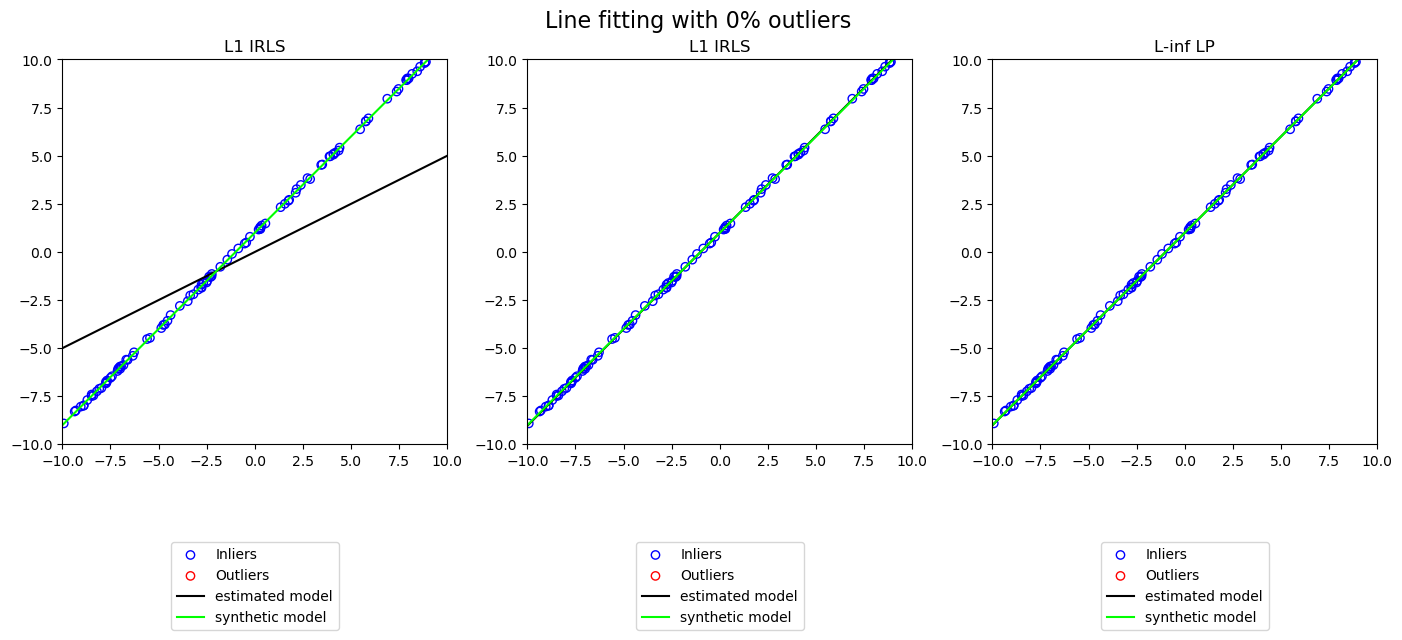

IRLS L1: Polynomial([0.0, 0.5])
LP L1: Polynomial([1.003064278414635, 1.0036197504937188])
LP L-inf: Polynomial([0.9999250693489281, 1.0005873251685975])


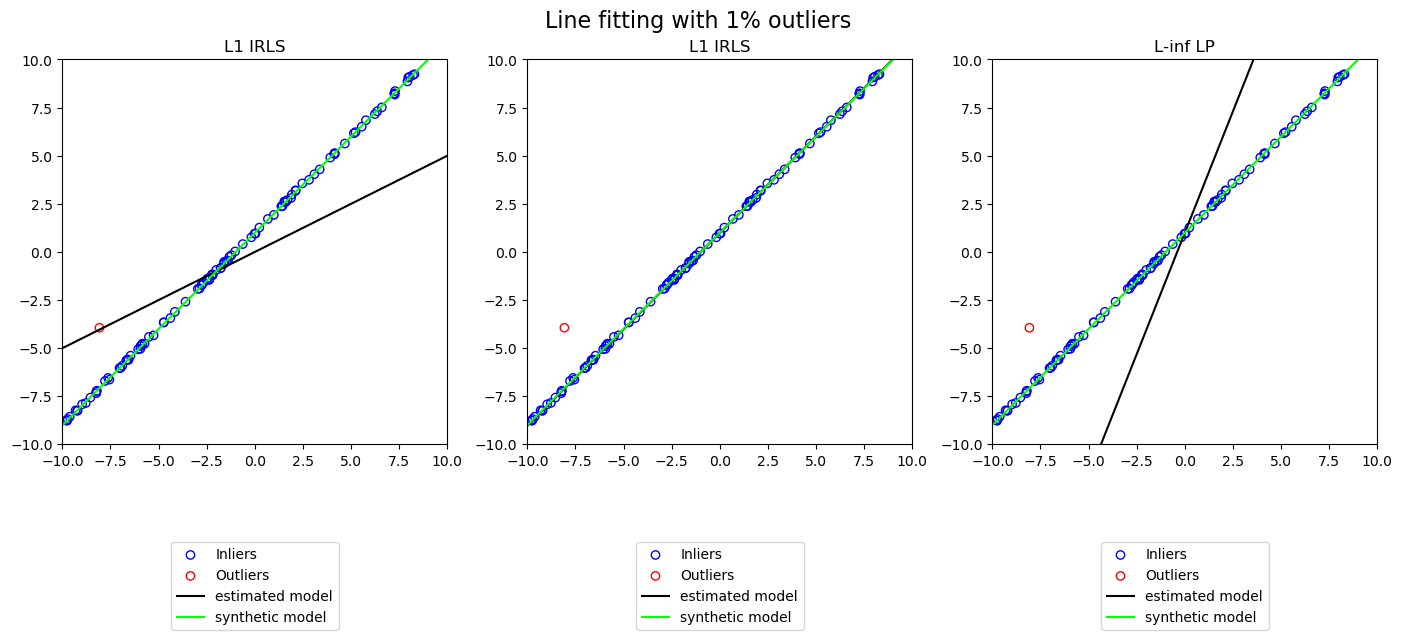

IRLS L1: Polynomial([0.0, 0.5])
LP L1: Polynomial([0.9964208099177597, 1.0027580837591152])
LP L-inf: Polynomial([1.0003437202402898, 2.523286052116204])


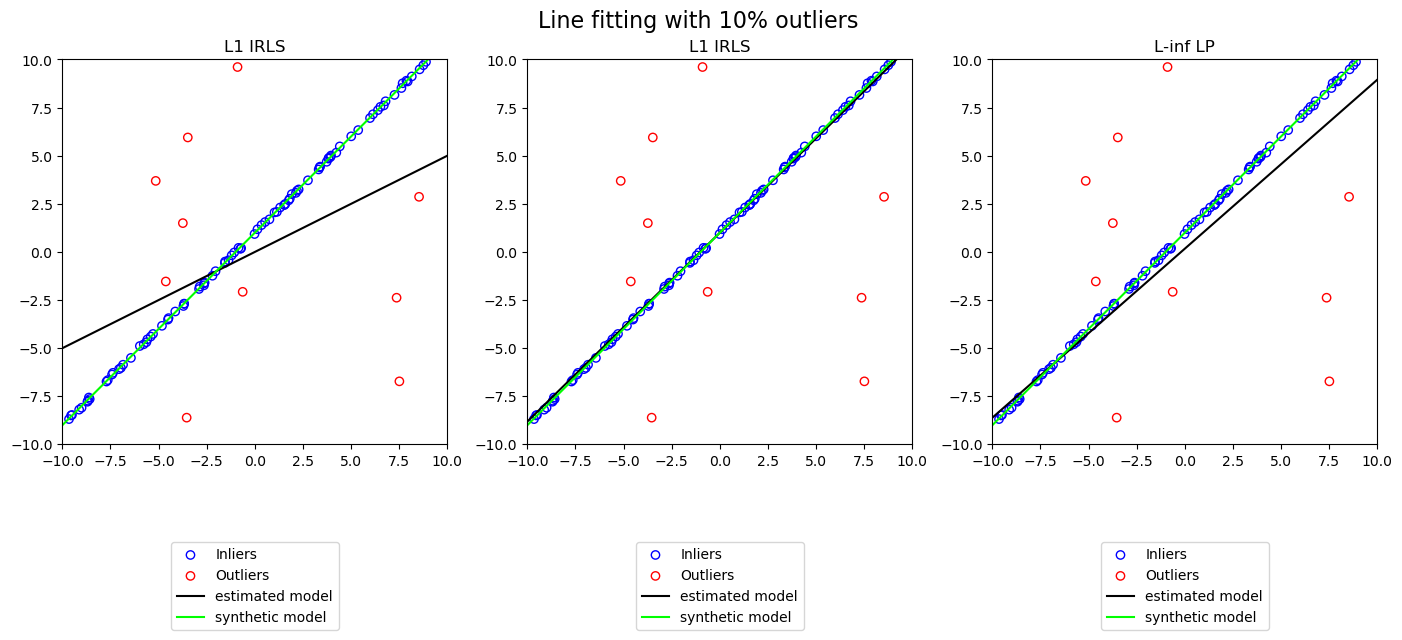

IRLS L1: Polynomial([0.0, 0.5])
LP L1: Polynomial([0.9986010886288083, 0.9809291256515493])
LP L-inf: Polynomial([0.17069305367251922, 0.8780470381959162])


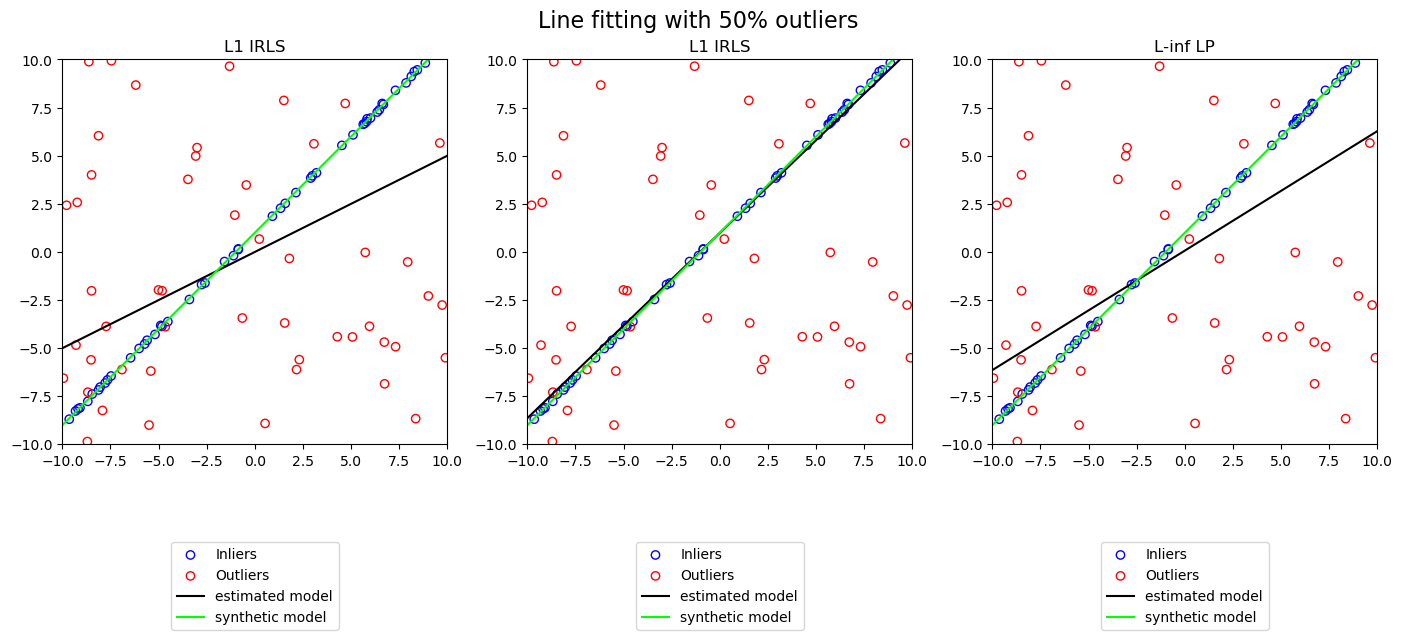

IRLS L1: Polynomial([0.0, 0.5])
LP L1: Polynomial([0.9915229068457931, 0.9626491830338539])
LP L-inf: Polynomial([0.06980706671612542, 0.6208178352000271])


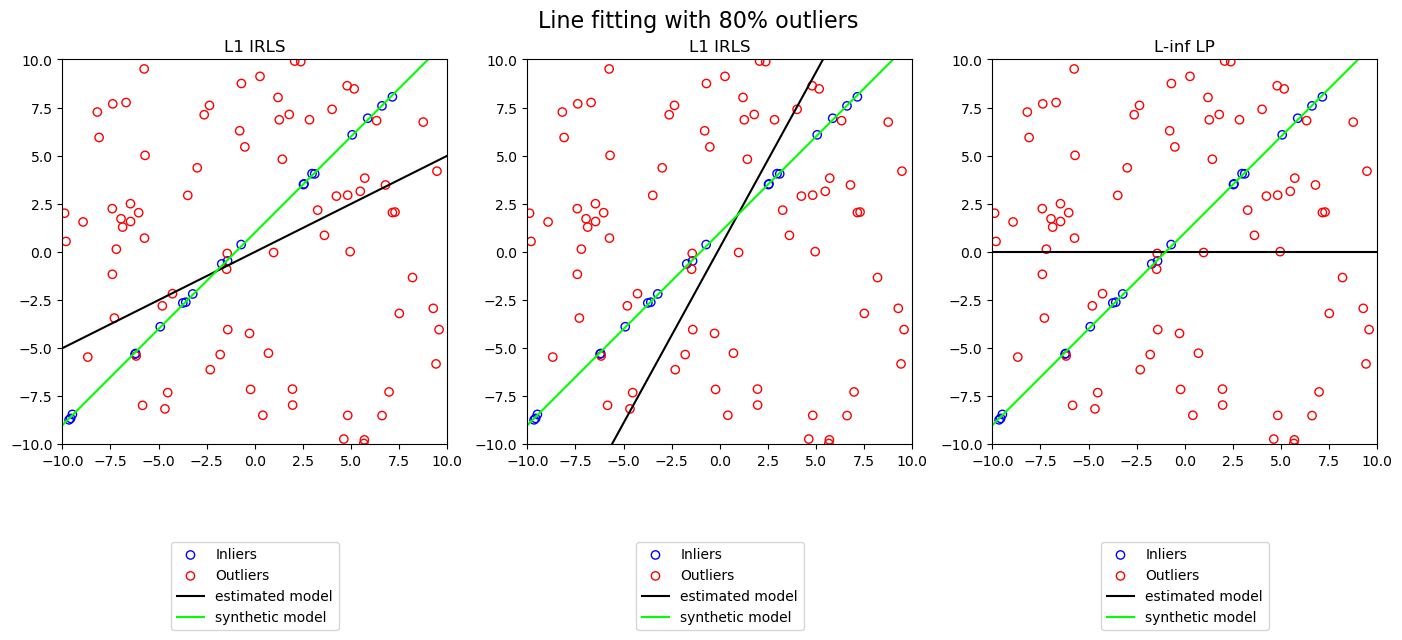

IRLS L1: Polynomial([0.0, 0.5])
LP L1: Polynomial([0.2335101977741402, 1.823008756837096])
LP L-inf: Polynomial([0.0, 0.0])


In [62]:
# Plotting the results. No need to change this code
for r in [0.0, 0.01, 0.1, 0.5, 0.8]:
    inliers, outliers = poly_b.generate_points(r)
    points = np.concatenate((inliers, outliers), 0)

    irls_l1_line = fit_line_irls_l1(points)
    lp_l1_line = fit_line_lp_l1(points)
    lp_l_inf_line = fit_line_lp_l_inf(points)

    fig, axes = plt.subplots(1, 3, figsize=(17, 5))
    
    fig.suptitle(f'Line fitting with {r*100:.0f}% outliers', fontsize=16)
    
    plot_models(axes[0], inliers, outliers, poly_b, irls_l1_line, title="L1 IRLS")
    plot_models(axes[1], inliers, outliers, poly_b, lp_l1_line, title="L1 IRLS")
    plot_models(axes[2], inliers, outliers, poly_b, lp_l_inf_line, title="L-inf LP")
    
    plt.show()
    plt.close(fig)
    
    print(f"IRLS L1: {irls_l1_line}")
    print(f"LP L1: {lp_l1_line}")
    print(f"LP L-inf: {lp_l_inf_line}")


In [ ]:
# Comparison with RANSAC
r = 0.8
inliers, outliers = poly_b.generate_points(r)
points = np.concatenate((inliers, outliers), 0)

sample_size = poly_b.degree + 1
n_iter = get_ransac_iterations(r, sample_size, 0.99)
_, _, ransac_line = run_ransac(points, n_iter, sample_size)

lp_l1_line = fit_line_lp_l1(points)
lp_l_inf_line = fit_line_lp_l_inf(points)

fig, axes = plt.subplots(1, 3, figsize=(17, 5))
    
fig.suptitle(f'Line fitting with {r*100:.0f}% outliers', fontsize=16)
    
plot_models(axes[0], inliers, outliers, poly_b, ransac_line, title="RANSAC")
plot_models(axes[1], inliers, outliers, poly_b, lp_l1_line, title="L1")
plot_models(axes[2], inliers, outliers, poly_b, lp_l_inf_line, title="L-inf")
    
plt.show()
plt.close(fig)

### Discussion 

<b style="color:red"> Question 2.1:</b> Discuss the results obtained by IRLS/LP solutions.

_TODO_: Your answer here

<b style="color:red"> Question 2.2:</b> Compare and contrast them with RANSAC. What are the key differences between these two approaches? Under what circumstances might one be more suitable than the other?

_TODO_: Your answer here